In [26]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import os
import pandas as pd
import numpy as np 
import plotnine as pn 

Make sure to download clumps_count and the folder of the images of the clumps off of the google drive! 

In [3]:
# read in labels 
labels = pd.read_csv('clumps_count.csv')

In [4]:
labels.dropna(inplace=True) 

In [5]:
labels.head()

,clump,Number of Adult Female Seals,Number of Baby Seals,Number of Adult Male Seals,Total Number of Seals
0,LS21323_DJI_0001_clump_0001,1.0,1.0,0.0,2.0
1,LS21323_DJI_0001_clump_0002,4.0,4.0,0.0,8.0
2,LS21323_DJI_0001_clump_0003,4.0,5.0,0.0,9.0
3,LS21323_DJI_0001_clump_0004,1.0,1.0,0.0,2.0
4,LS21323_DJI_0001_clump_0005,1.0,1.0,0.0,2.0


In [6]:
len(labels)

704

In [7]:
# split 
train_val_labels, test_labels = train_test_split(labels, test_size=1/5, random_state=452)
train_labels, val_labels = train_test_split(train_val_labels, test_size=1/8, random_state=452)

In [8]:
train_imgs = train_labels['clump'].values
val_imgs = val_labels['clump'].values 
test_imgs = test_labels['clump'].values 

In [10]:
# preprocessing 
class SealDataset(Dataset): 
    def __init__(self, img_dir, img_ids, labels, transform_pipeline):
        self.img_dir = img_dir
        self.img_ids = img_ids 
        self.labels = labels 
        self.transform_pipeline = transform_pipeline

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        row = self.labels.iloc[idx]

        img_path = os.path.join(self.img_dir, f'{self.img_ids[idx]}.tif')
        image = self.transform_pipeline(Image.open(img_path).convert('RGB'))
        
        label = torch.tensor([
            row['Number of Adult Male Seals'], 
            row['Number of Adult Female Seals'],
            row['Number of Baby Seals']
        ], dtype=torch.float32)

        return image, label

In [11]:
# transformation pipeline 
transform_pl = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [12]:
# loading to class
img_dir = '../../elephant-seals-image-extraction/scripts/clumps' # img dir of clump imgs  

train_set = SealDataset(img_dir, train_imgs, train_labels, transform_pl)
val_set = SealDataset(img_dir, val_imgs, val_labels, transform_pl)
test_set = SealDataset(img_dir, test_imgs, test_labels, transform_pl)

train_loader = DataLoader(train_set, batch_size=32)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)

In [13]:
# model 
class SealCountRegressor(nn.Module):
    def __init__(self):
        super(SealCountRegressor, self).__init__()
        self.backbone = models.resnet50(pretrained=True)
        self.backbone.fc = nn.Identity()
        self.regressor = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 3),
            nn.Softplus()
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.regressor(features)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [15]:
model = SealCountRegressor()
model = model.to(device) 

c:\Users\Brandon Kim\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Brandon Kim\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [16]:
criterion = nn.PoissonNLLLoss(log_input=False) # poisson cuz count data 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [17]:
# model training 
for epoch in range(10):
    model.train()
    running_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device) 

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()*images.size(0)

    print(f"Epoch {epoch+1} - Loss: {running_loss / len(train_loader.dataset):.4f}")

    model.eval()
    val_loss = 0 
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device) 

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
        
        print(f'Val Loss: {val_loss / len(val_loader):.4f}')

Epoch 1 - Loss: 0.7983
Val Loss: 0.6562
Epoch 2 - Loss: 0.5822
Val Loss: 0.6249
Epoch 3 - Loss: 0.5195
Val Loss: 0.5675
Epoch 4 - Loss: 0.4916
Val Loss: 0.5586
Epoch 5 - Loss: 0.4804
Val Loss: 0.5476
Epoch 6 - Loss: 0.4721
Val Loss: 0.5560
Epoch 7 - Loss: 0.4691
Val Loss: 0.5512
Epoch 8 - Loss: 0.4659
Val Loss: 0.5529
Epoch 9 - Loss: 0.4604
Val Loss: 0.5473
Epoch 10 - Loss: 0.4528
Val Loss: 0.5423


In [18]:
# eval
model.eval()
predicted_males = []
predicted_females = []
predicted_cubs = []

actual_males = []
actual_females = []
actual_cubs = [] 

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)

        outputs = model(images).cpu()

        for output, label in zip(outputs, labels): 

            predicted_males.append(output[0].item())
            predicted_females.append(output[1].item())
            predicted_cubs.append(output[2].item())

            actual_males.append(label[0].item())
            actual_females.append(label[1].item())
            actual_cubs.append(label[2].item())

predicted_males = np.array(predicted_males)
predicted_females = np.array(predicted_females)
predicted_cubs = np.array(predicted_cubs)
actual_males = np.array(actual_males)
actual_females = np.array(actual_females)
actual_cubs = np.array(actual_cubs)

mae_male = np.mean(np.abs(predicted_males - actual_males))
mae_female = np.mean(np.abs(predicted_females - actual_females))
mae_cubs = np.mean(np.abs(predicted_cubs - actual_cubs))

print(f"MAE - Adult Males:   {mae_male:.2f}")
print(f"MAE - Adult Females: {mae_female:.2f}")
print(f"MAE - Cubs:          {mae_cubs:.2f}")

MAE - Adult Males:   0.01
MAE - Adult Females: 0.26
MAE - Cubs:          0.37


In [30]:
pva = pd.DataFrame({
    'predicted_males': predicted_males, 
    'predicted_females': predicted_females, 
    'predicted_cubs': predicted_cubs,
    'actual_males': actual_males,
    'actual_females': actual_females,
    'actual_cubs': actual_cubs
})

In [40]:
pva.groupby(['actual_females']).mean()['predicted_females']

actual_females
0.0    0.222474
1.0    0.949462
2.0    1.691445
3.0    2.299800
4.0    3.160131
5.0    2.588443
Name: predicted_females, dtype: float64

In [41]:
pva.groupby(['actual_females']).size()

actual_females
0.0    16
1.0    80
2.0    36
3.0     5
4.0     3
5.0     1
dtype: int64

In [43]:
pva.groupby(['actual_cubs']).mean()['predicted_cubs']

actual_cubs
0.0    0.873427
1.0    1.171978
2.0    1.915173
3.0    2.365709
4.0    2.651103
5.0    3.330888
Name: predicted_cubs, dtype: float64

In [44]:
pva.groupby(['actual_cubs']).size()

actual_cubs
0.0     9
1.0    84
2.0    27
3.0    13
4.0     6
5.0     2
dtype: int64

In [37]:
females_long = pva[['predicted_females', 'actual_females']].melt(var_name = 'var', value_name = 'value')
cubs_long = pva[['predicted_cubs', 'actual_cubs']].melt(var_name = 'var', value_name = 'value')

c:\Users\Brandon Kim\AppData\Local\Programs\Python\Python310\lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 21'. Pick better value with 'binwidth'.


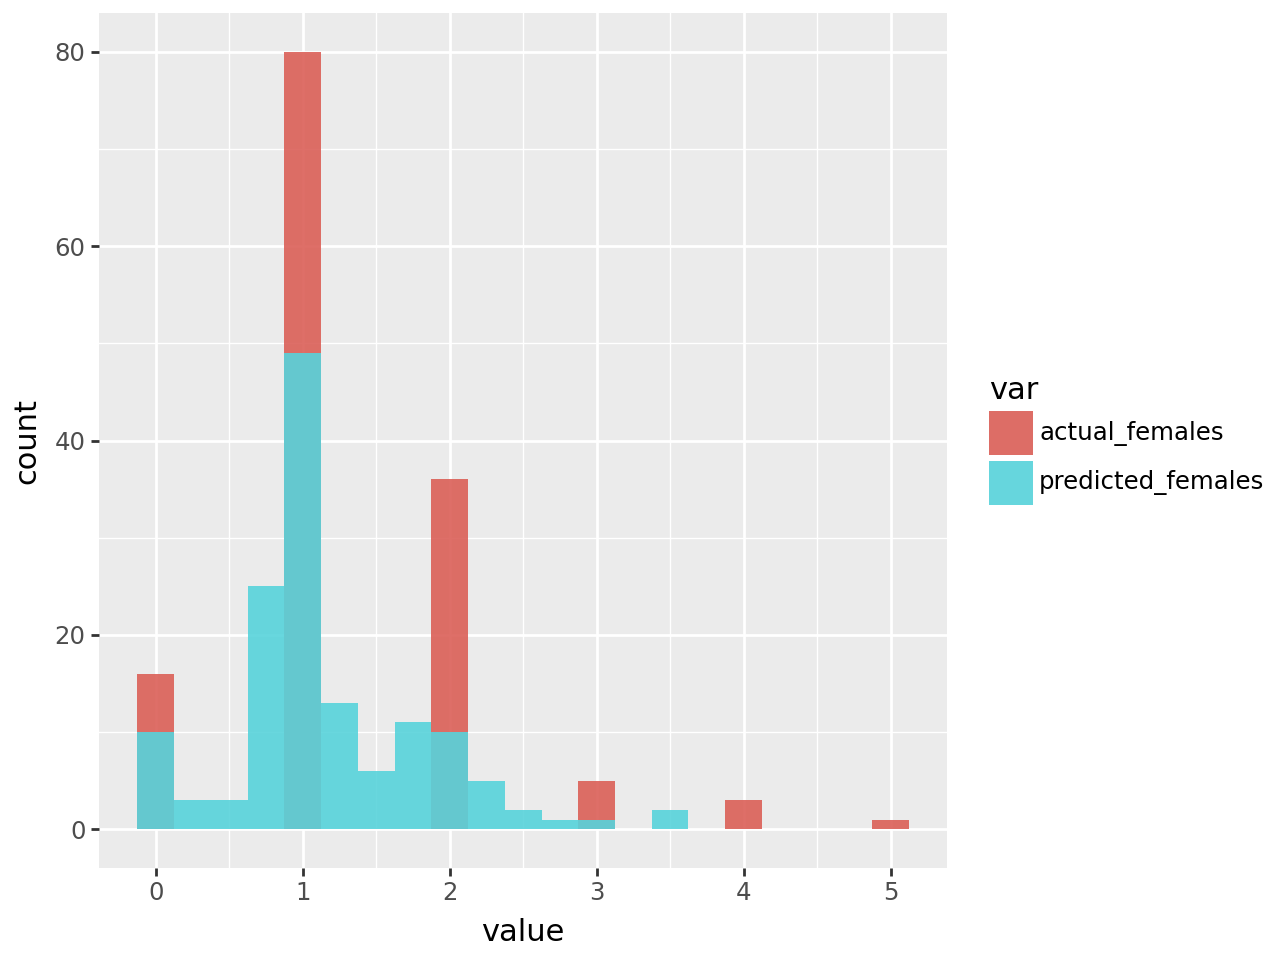

In [ ]:
(
    pn.ggplot(females_long, pn.aes(x = 'value', fill = 'var')) +
    pn.geom_histogram(alpha=0.9, position= 'identity') 

)

c:\Users\Brandon Kim\AppData\Local\Programs\Python\Python310\lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 17'. Pick better value with 'binwidth'.


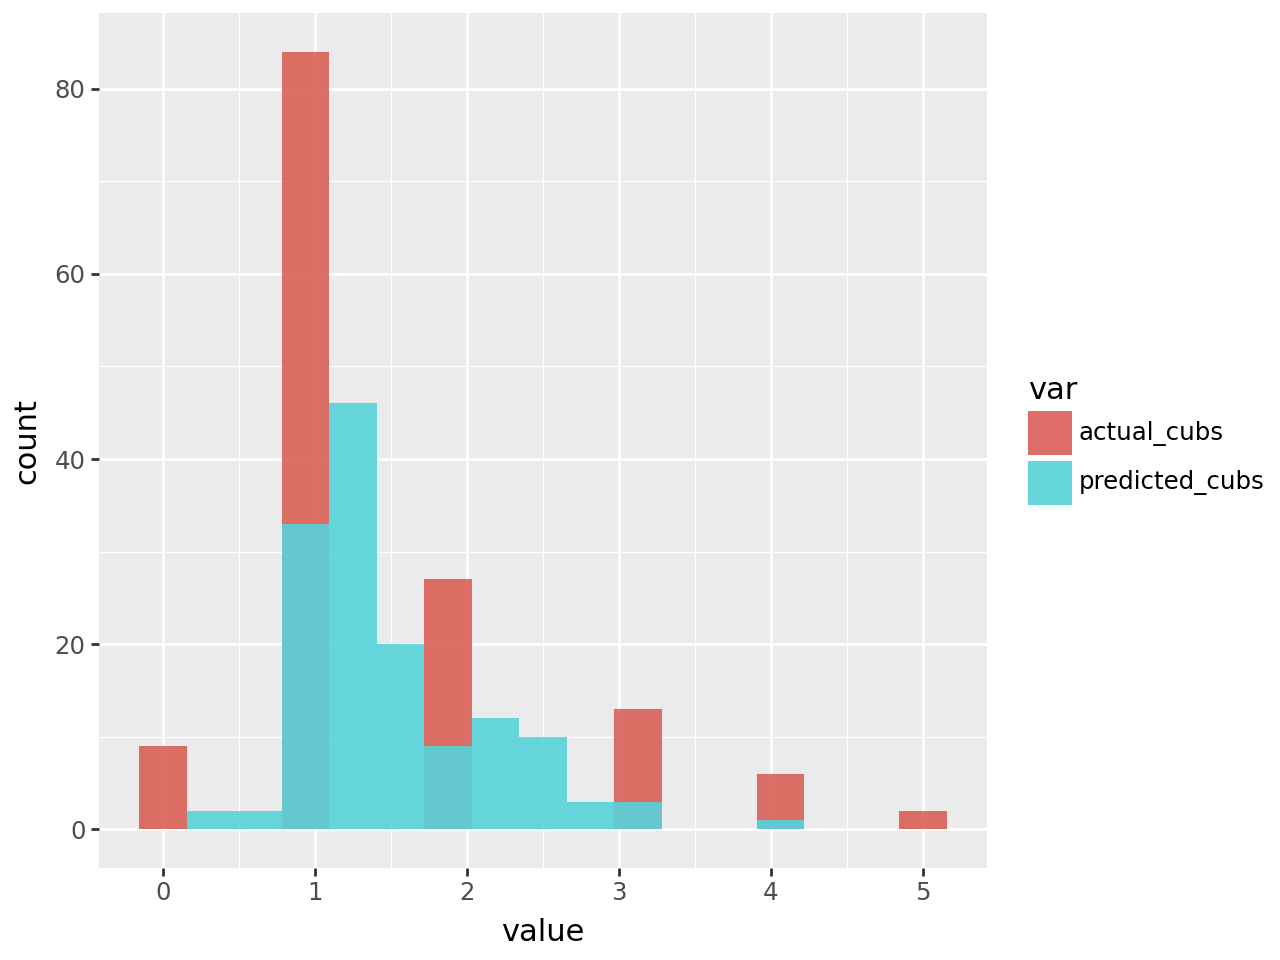

In [38]:
(
    pn.ggplot(cubs_long, pn.aes(x = 'value', fill = 'var')) +
    pn.geom_histogram(alpha=0.9, position= 'identity') 

)